In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to Vertex AI Embeddings - Text & Multimodal

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/embeddings/intro_multimodal_embeddings.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fembeddings%2Fintro_multimodal_embeddings.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/embeddings/intro_multimodal_embeddings.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/embeddings/intro_multimodal_embeddings.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
</table>

| | |
|-|-|
|Author(s) | [Lavi Nigam](https://github.com/lavinigam-gcp) , [Kaz Sato]()  |

### Objectives

In this notebook, you will explore:
* Vertex AI Multimodal Embeddings API (Texts, Images & Video)
* Building simple search with e-commerce data
    - Find product based on text query
    - Find product based on image
    - Find Video based on video

## Multimodal Embeddings

[Vertex AI Multimodal Embeddings API](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-multimodal-embeddings) generates [ 128, 256, 512, and 1408 (default) ] -dimension vectors based on the input you provide, which can include a combination of image, text, and video data. The embedding vectors can then be used for subsequent tasks like image classification or video content moderation.

The image embedding vector and text embedding vector generated with this API shares the semantic space. Consequently, these vectors can be used interchangeably for use cases like searching image by text, or searching video by image.

**Use cases**

**Image and text:**

* Image classification: Takes an image as input and predicts one or more classes (labels).
* Image search: Search relevant or similar images.
* Recommendations: Generate product or ad recommendations based on images.

**Image, text, and video:**

* Recommendations: Generate product or advertisement recommendations based on videos (similarity search).
* Video content search
    * Using semantic search: Take a text as an input, and return a set of ranked frames matching the query.
* Using similarity search:
    * Take a video as an input, and return a set of videos matching the query.
    * Take an image as an input, and return a set of videos matching the query.
* Video classification: Takes a video as input and predicts one or more classes.

## Getting Started

### Install Vertex AI SDK for Python and other dependencies

In [ ]:
%pip install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
# Define project information

import sys

# if not running on Colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()
else:
    PROJECT_ID = "[YOUR PROJECT ID]"  # @param {type:"string"}
LOCATION = "us-central1"

print(f"Your project ID is: {PROJECT_ID}")

Your project ID is: gcp-samples-ic0


In [3]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [4]:
# for image processing

# for data processing
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

# for showing images and videos
from IPython.display import HTML
from IPython.display import Image as ImageByte
from IPython.display import display

# vertex ai sdk
import vertexai
from vertexai.vision_models import Image as VMImage
from vertexai.vision_models import MultiModalEmbeddingModel
from vertexai.vision_models import Video as VMVideo
from vertexai.vision_models import VideoSegmentConfig

### Load Vertex AI Text and Multimodal Embeddings

In [5]:
mm_embedding_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

## Generate Text Embeddings

In [6]:
def get_text_embedding(
    text: str = "banana muffins",
    dimension: int | None = 1408,
) -> list[float]:
    embedding = mm_embedding_model.get_embeddings(
        contextual_text=text,
        dimension=dimension,
    )
    return embedding.text_embedding

In [7]:
text_emb = get_text_embedding(text="What is life?")
print("length of embedding: ", len(text_emb))
print("First five values are: ", text_emb[:5])

length of embedding:  1408
First five values are:  [-0.0211111214, -0.0376161486, 0.00776624819, -0.00773079833, 0.0153800147]


#### Embeddings and Pandas DataFrames

If your text is stored in a column of a DataFrame, you can create a new column with the embeddings with the example below.

In [8]:
import pandas as pd

text = [
    "i really enjoyed the movie last night",
    "so many amazing cinematic scenes yesterday",
    "had a great time writing my Python scripts a few days ago",
    "huge sense of relief when my .py script finally ran without error",
    "O Romeo, Romeo, wherefore art thou Romeo?",
]

df = pd.DataFrame(text, columns=["text"])
df

,text
0,i really enjoyed the movie last night
1,so many amazing cinematic scenes yesterday
2,had a great time writing my Python scripts a f...
3,huge sense of relief when my .py script finall...
4,"O Romeo, Romeo, wherefore art thou Romeo?"


Create a new column, `embeddings`, using the [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) function in pandas with the embeddings model.

In [9]:
df["embedding"] = df.apply(lambda x: get_text_embedding(x.text), axis=1)
df

,text,embedding
0,i really enjoyed the movie last night,"[0.00766784186, -0.0263111852, -0.00322942785,..."
1,so many amazing cinematic scenes yesterday,"[-0.00605897605, -0.0173093341, 0.0134883579, ..."
2,had a great time writing my Python scripts a f...,"[0.0103363758, 0.00213950383, 0.000450726831, ..."
3,huge sense of relief when my .py script finall...,"[0.0146734193, -0.045813, 0.014104994, -0.0010..."
4,"O Romeo, Romeo, wherefore art thou Romeo?","[0.0184159577, -0.0649260134, -0.0103790155, -..."


#### Comparing similarity of text examples using cosine similarity

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_array = cosine_similarity(list(df.embedding.values))

# display as DataFrame
df = pd.DataFrame(cos_sim_array, index=text, columns=text)
df

,i really enjoyed the movie last night,so many amazing cinematic scenes yesterday,had a great time writing my Python scripts a few days ago,huge sense of relief when my .py script finally ran without error,"O Romeo, Romeo, wherefore art thou Romeo?"
i really enjoyed the movie last night,1.000000,0.804743,0.707345,0.474272,0.387895
so many amazing cinematic scenes yesterday,0.804743,1.000000,0.673480,0.449804,0.375416
had a great time writing my Python scripts a few days ago,0.707345,0.673480,1.000000,0.457659,0.337939
huge sense of relief when my .py script finally ran without error,0.474272,0.449804,0.457659,1.000000,0.399580
"O Romeo, Romeo, wherefore art thou Romeo?",0.387895,0.375416,0.337939,0.399580,1.000000


To make this easier to understand, you can use a heatmap. Naturally, text is most similar when they are identical (score of 1.0). The next highest scores are when sentences are semantically similar. The lowest scores are when sentences are quite different in meaning.

[Text(0.5, 1, 'i really enjoyed the movie last night'),
 Text(1.5, 1, 'so many amazing cinematic scenes yesterday'),
 Text(2.5, 1, 'had a great time writing my Python scripts a few days ago'),
 Text(3.5, 1, 'huge sense of relief when my .py script finally ran without error'),
 Text(4.5, 1, 'O Romeo, Romeo, wherefore art thou Romeo?')]

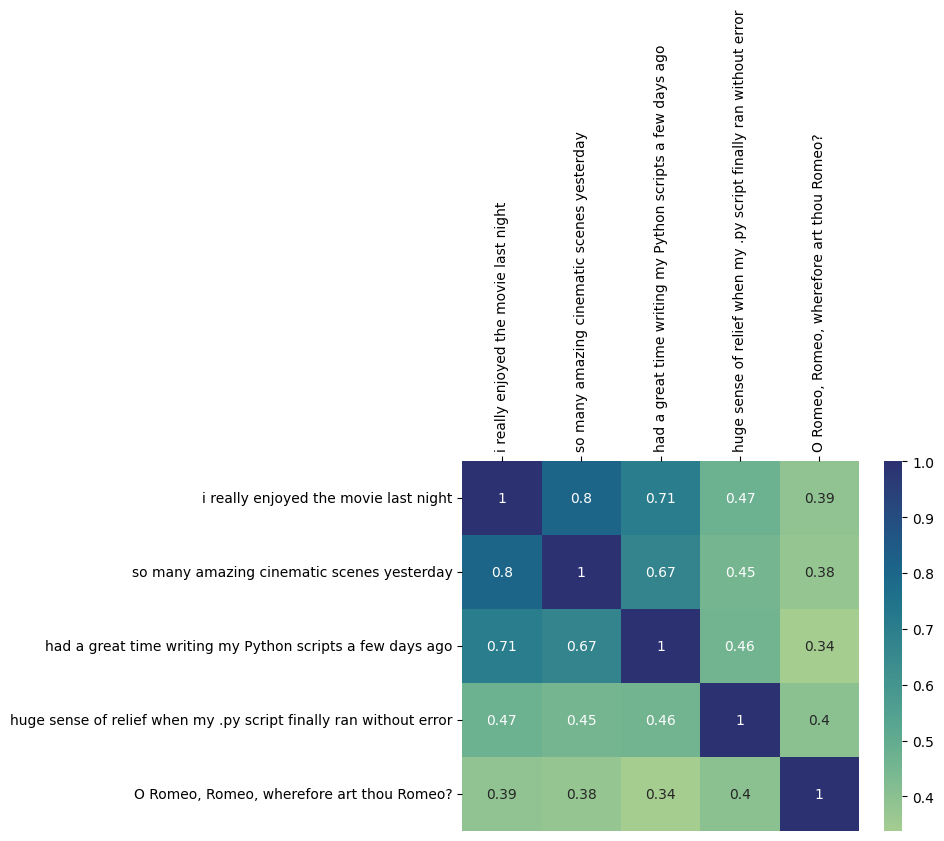

In [11]:
import seaborn as sns

ax = sns.heatmap(df, annot=True, cmap="crest")
ax.xaxis.tick_top()
ax.set_xticklabels(text, rotation=90)

## Generate Image Embeddings

In [14]:
def get_image_embedding(
    image_path: str = None,
    dimension: int | None = 1408,
) -> list[float]:
    image = VMImage.load_from_file(image_path)
    embedding = mm_embedding_model.get_embeddings(
        image=image,
        dimension=dimension,
    )
    return embedding.image_embedding

In [15]:
def get_public_url_from_gcs(gcs_uri: str) -> str:
    return gcs_uri.replace("gs://", "https://storage.googleapis.com/").replace(
        " ", "%20"
    )

In [17]:
# Image embeddings with default 1408 dimension
image_path = "gs://github-repo/embeddings/getting_started_embeddings/gms_images/GGOEACBA104999.jpg"
print(get_public_url_from_gcs(image_path))

image_emb = get_image_embedding(
    image_path=image_path,
)
print("length of embedding: ", len(image_emb))
print("First five values are: ", image_emb[:5])

https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/gms_images/GGOEACBA104999.jpg
length of embedding:  1408
First five values are:  [-0.000501763599, 0.0334774517, -0.0165628586, 0.0210418757, -0.00548506668]


### Find product images based on text search query

In [18]:
# get product list with pre-computed image embeddings
product_image_list = pd.read_csv(
    "https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/image_data_with_embeddings.csv"
)
product_image_list.head()

,parent_sku,parent_description,retail_price,img_url,seo_url,title,shortdesc,longdesc,keywords,metadescription,file_path,gcs_path,combined_text,image_embeddings,text_embeddings
0,GGOEAXXX1947,Android Keyboard Sticker,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Android Keyboard Sticker,Add some character to your keyboard! This sma...,"<div><p dir=""ltr""><span>Sticker measures ½ x ...",Android Keyboard Sticker,Shop Google Merchandise store for Android Keyb...,/content/data/gms_images/GGOEAFKA194799.jpg,gs://github-repo/embeddings/getting_started_em...,Android Keyboard Sticker Android Keyboard Stic...,"[-0.019712951, -0.00683932705, 0.0385046713, 0...","[-0.0003441123408265412, -0.020794985815882683..."
1,GGOEGXXX1238,Google Pen Neon Coral,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Pen Neon Coral,Whether you are signing official documents or ...,<div><p>Soft touch surface.</p><p>Fine point g...,"Google Pen Neon Coral, Google, pen, orange, co...",Shop Google Merchandise Store for Google Pen N...,/content/data/gms_images/GGOEGOAN123899.jpg,gs://github-repo/embeddings/getting_started_em...,"Google Pen Neon Coral Google Pen Neon Coral, G...","[0.0312964357, 0.0266801305, -0.00428772392, 0...","[0.015119598247110844, -0.05192413181066513, -..."
2,GGOEGXXX1983,Google Hologram Sunnyvale Campus Sticker,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Hologram Sunnyvale Campus Sticker,"Nostalgic and fun for everyone, our exclusive ...","<div><p dir=""ltr""><span>Sticker measures 3 H</...",Google Hologram Sunnyvale Campus Sticker,Shop Google Merchandise store for Google Holog...,/content/data/gms_images/GGOEGCKA198399.jpg,gs://github-repo/embeddings/getting_started_em...,Google Hologram Sunnyvale Campus Sticker Googl...,"[-0.0115588326, 0.0233894847, 0.0509909727, 0....","[0.008340244181454182, -0.019928857684135437, ..."
3,GGOEGXXX1773,Google Maps Wheat Pen,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Maps Wheat Pen,Drop your pen to paper and start planning your...,<div><p>Black Ink </p><p>Retractable medium ba...,Google Maps Wheat Pen,Shop Google Merchandise Store for Google Maps ...,/content/data/gms_images/GGOEGOAB177399.jpg,gs://github-repo/embeddings/getting_started_em...,Google Maps Wheat Pen Google Maps Wheat Pen Sh...,"[0.0108120618, 0.0177407321, -0.0159502737, 0....","[0.0009172282880172133, -0.05302327498793602, ..."
4,GGOECXXX1946,Google Cloud Keyboard Sticker,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Cloud Keyboard Sticker,Add some character to your keyboard! This sma...,"<div><p dir=""ltr""><span>Sticker measures ½ x ...",Google Cloud Keyboard Sticker,Shop Google Merchandise store for Google Cloud...,/content/data/gms_images/GGOECFKA194699.jpg,gs://github-repo/embeddings/getting_started_em...,Google Cloud Keyboard Sticker Google Cloud Key...,"[-0.0243009, 0.0230779219, 0.039797049, 0.0337...","[0.015464423224329948, -0.025598861277103424, ..."


In [19]:
def print_similar_products(query_emb, data_frame):
    # calc dot product
    image_embs = data_frame["image_embeddings"]
    scores = [np.dot(eval(image_emb), query_emb) for image_emb in image_embs]
    data_frame["score"] = scores
    data_frame = data_frame.sort_values(by="score", ascending=False)

    # print results
    print(data_frame.head()[["score", "title"]])
    for url in data_frame.head()["img_url"]:
        display(ImageByte(url=url, width=200, height=200))

In [20]:
# calc_scores for a text query
query_emb = get_text_embedding("something related to dinosaurs theme")
print_similar_products(query_emb, product_image_list)

        score                              title
235  0.120895  Chrome Dino Collectible Figurines
15   0.105889       Chrome Dino Keyboard Sticker
84   0.098711               Chrome Dino Keychain
91   0.098204        YouTube Kids T-Rex Keychain
252  0.097236         Chrome Dino Food Container


In [21]:
query_emb = get_text_embedding("Socks in checkered patterns")
print_similar_products(query_emb, product_image_list)

        score                             title
133  0.128208                 Google Bike Socks
146  0.104420          YouTube Expressive Socks
141  0.096457       YouTube Tie-Dye Woven Socks
131  0.092857                 Chrome Dino Socks
66   0.090372  Google Checkered Shoelaces White


## Generate Video Embeddings

In [22]:
def get_video_embedding(
    video_path: str,
    dimension: int | None = 1408,
    video_segment_config: VideoSegmentConfig | None = None,
) -> list[float]:
    video = VMVideo.load_from_file(video_path)
    embedding = mm_embedding_model.get_embeddings(
        video=video,
        dimension=dimension,
        video_segment_config=video_segment_config,
    )
    return [video_emb.embedding for video_emb in embedding.video_embeddings]

In [23]:
def display_video_from_gcs(
    gcs_uri: str = None,
) -> None:
    html_code = f"""
    <video width="640" height="480" controls>
        <source src="{get_public_url_from_gcs(gcs_uri)}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
    display(HTML(html_code))

In [24]:
# Video embeddings with 1408 dimension


video_path = "gs://github-repo/embeddings/getting_started_embeddings/UCF-101-subset/BrushingTeeth/v_BrushingTeeth_g01_c02.mp4"
display_video_from_gcs(video_path)

video_emb = get_video_embedding(
    video_path=video_path,
)

print("length of embedding: ", len(video_emb[0]))
print("First five values of the first segment are: ", video_emb[0][:5])

length of embedding:  1408
First five values of the first segment are:  [-0.0117426617, 0.0195700061, -0.00300012343, -0.0172459967, -0.00545583107]


### Find videos based on text search query

In [45]:
video_list = pd.read_csv(
    "https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/video_data_with_embeddings.csv"
)
print(f"Items in the video list: {len(video_list)}")
video_list.head()

Items in the video list: 50


,Unnamed: 0,gcs_path,category,file_name,video_embeddings
0,0,gs://github-repo/embeddings/getting_started_em...,TaiChi,v_TaiChi_g25_c04.mp4,"[0.0212469846, 0.021904517, 0.00673244661, 0.0..."
1,1,gs://github-repo/embeddings/getting_started_em...,TaiChi,v_TaiChi_g25_c03.mp4,"[0.0150156552, 0.0182044469, 0.00531015405, 0...."
2,2,gs://github-repo/embeddings/getting_started_em...,TaiChi,v_TaiChi_g13_c03.mp4,"[0.0176973231, 0.0306478031, 0.0060283, 0.0190..."
3,3,gs://github-repo/embeddings/getting_started_em...,TaiChi,v_TaiChi_g21_c04.mp4,"[0.00879747886, 0.00810849108, -0.00468777, 0...."
4,4,gs://github-repo/embeddings/getting_started_em...,TaiChi,v_TaiChi_g07_c02.mp4,"[0.0203397758, -0.000400501624, 0.00930729136,..."


In [48]:
def print_similar_videos(query_emb, data_frame):
    # calc dot product
    video_embs = data_frame["video_embeddings"]
    scores = [np.dot(eval(video_emb), query_emb) for video_emb in video_embs]
    data_frame["score"] = scores
    data_frame = data_frame.sort_values(by="score", ascending=False)

    # print results
    print(data_frame.head()[["score", "file_name"]])
    url = data_frame.iloc[0]["gcs_path"]
    display_video_from_gcs(url)

In [52]:
query_emb = get_text_embedding("A music concert")
print_similar_videos(query_emb, video_list)

       score                    file_name
12  0.068436  v_PlayingViolin_g06_c02.mp4
10  0.061663  v_PlayingViolin_g13_c03.mp4
11  0.059950  v_PlayingViolin_g13_c01.mp4
14  0.059190  v_PlayingViolin_g24_c01.mp4
13  0.049865  v_PlayingViolin_g10_c04.mp4


In [53]:
query_emb = get_text_embedding("A person playing a TaiChi")
print_similar_videos(query_emb, video_list)

      score             file_name
3  0.179601  v_TaiChi_g21_c04.mp4
2  0.177981  v_TaiChi_g13_c03.mp4
4  0.161105  v_TaiChi_g07_c02.mp4
0  0.154910  v_TaiChi_g25_c04.mp4
1  0.153621  v_TaiChi_g25_c03.mp4


### Find Similar videos

Next in the series:

- Learn how to store the vectors (embeddings) into Vertex Vector Store: [Notebook](https://github.com/lavinigam-gcp/generative-ai/blob/main/embeddings/vector-search-quickstart.ipynb)

- Learn how to tune the embeddings with your own data: [Notebook](https://github.com/lavinigam-gcp/generative-ai/blob/main/embeddings/intro_embeddings_tuning.ipynb)

- Learn how to use embeddings to do Text RAG and Multimodal RAG: [Notebook](https://github.com/lavinigam-gcp/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb)